# $\bf\text{Problem 1}$

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

### The Circuit that marks 101, 100 & 111 is given by:

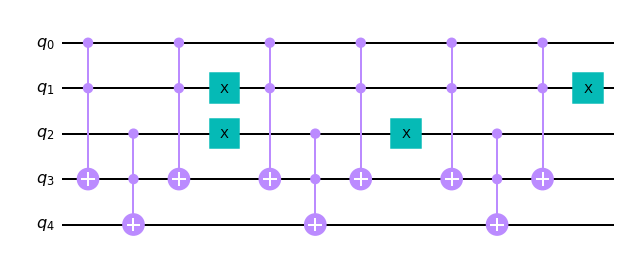

In [2]:
n=5
qc = QuantumCircuit(n)
qc.ccx(0,1,3);qc.ccx(2,3,4);qc.ccx(0,1,3)
#############
qc.x(1);qc.x(2)
qc.ccx(0,1,3);qc.ccx(2,3,4);qc.ccx(0,1,3)
qc.x(2)
#############
qc.ccx(0,1,3);qc.ccx(2,3,4);qc.ccx(0,1,3)
qc.x(1)
qc.draw('mpl')

In [3]:
"""Define function for this ORACLE"""
def phase_oracle2():
    qc = QuantumCircuit(n)
    qc.ccx(0,1,3);qc.ccx(2,3,4);qc.ccx(0,1,3)
    #############
    qc.x(1);qc.x(2)
    qc.ccx(0,1,3);qc.ccx(2,3,4);qc.ccx(0,1,3)
    qc.x(2)
    #############
    qc.ccx(0,1,3);qc.ccx(2,3,4);qc.ccx(0,1,3)
    qc.x(1)
    
    return qc

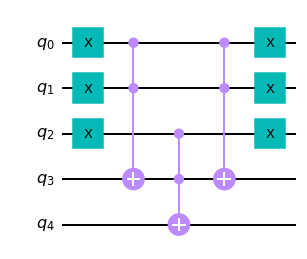

In [4]:
"""Part of DIFFUSER, that only marks 000"""
n=5
qc = QuantumCircuit(n)
for i in range(n-2):
    qc.x(i)
qc.ccx(0,1,3)
qc.ccx(2,3,4)
qc.ccx(0,1,3)
for i in range(n-2):
    qc.x(i)
qc.draw('mpl')

In [5]:
"""Define function for DIFFUSER"""
def diffuser(n, name='V'):
    qc = QuantumCircuit(n, name=name)
    
    for qb in range(n-2): #first layer of Hadamards in diffuser
        qc.h(qb)
   
    for i in range(n-2):
        qc.x(i)
    qc.ccx(0,1,3)
    qc.ccx(2,3,4)
    qc.ccx(0,1,3)
    for i in range(n-2):
        qc.x(i)
    
    for qb in range(n-2): #second layer of Hadamards in diffuser
        qc.h(qb)
        
    return qc

In [6]:
"""Convert the circuits to GATES"""
U_gate = phase_oracle2().to_gate()
U_gate.label = "U2"
Con_U =U_gate.control()
############################
V_gate = diffuser(n).to_gate()
V_gate.label = "V"
Con_V =V_gate.control()

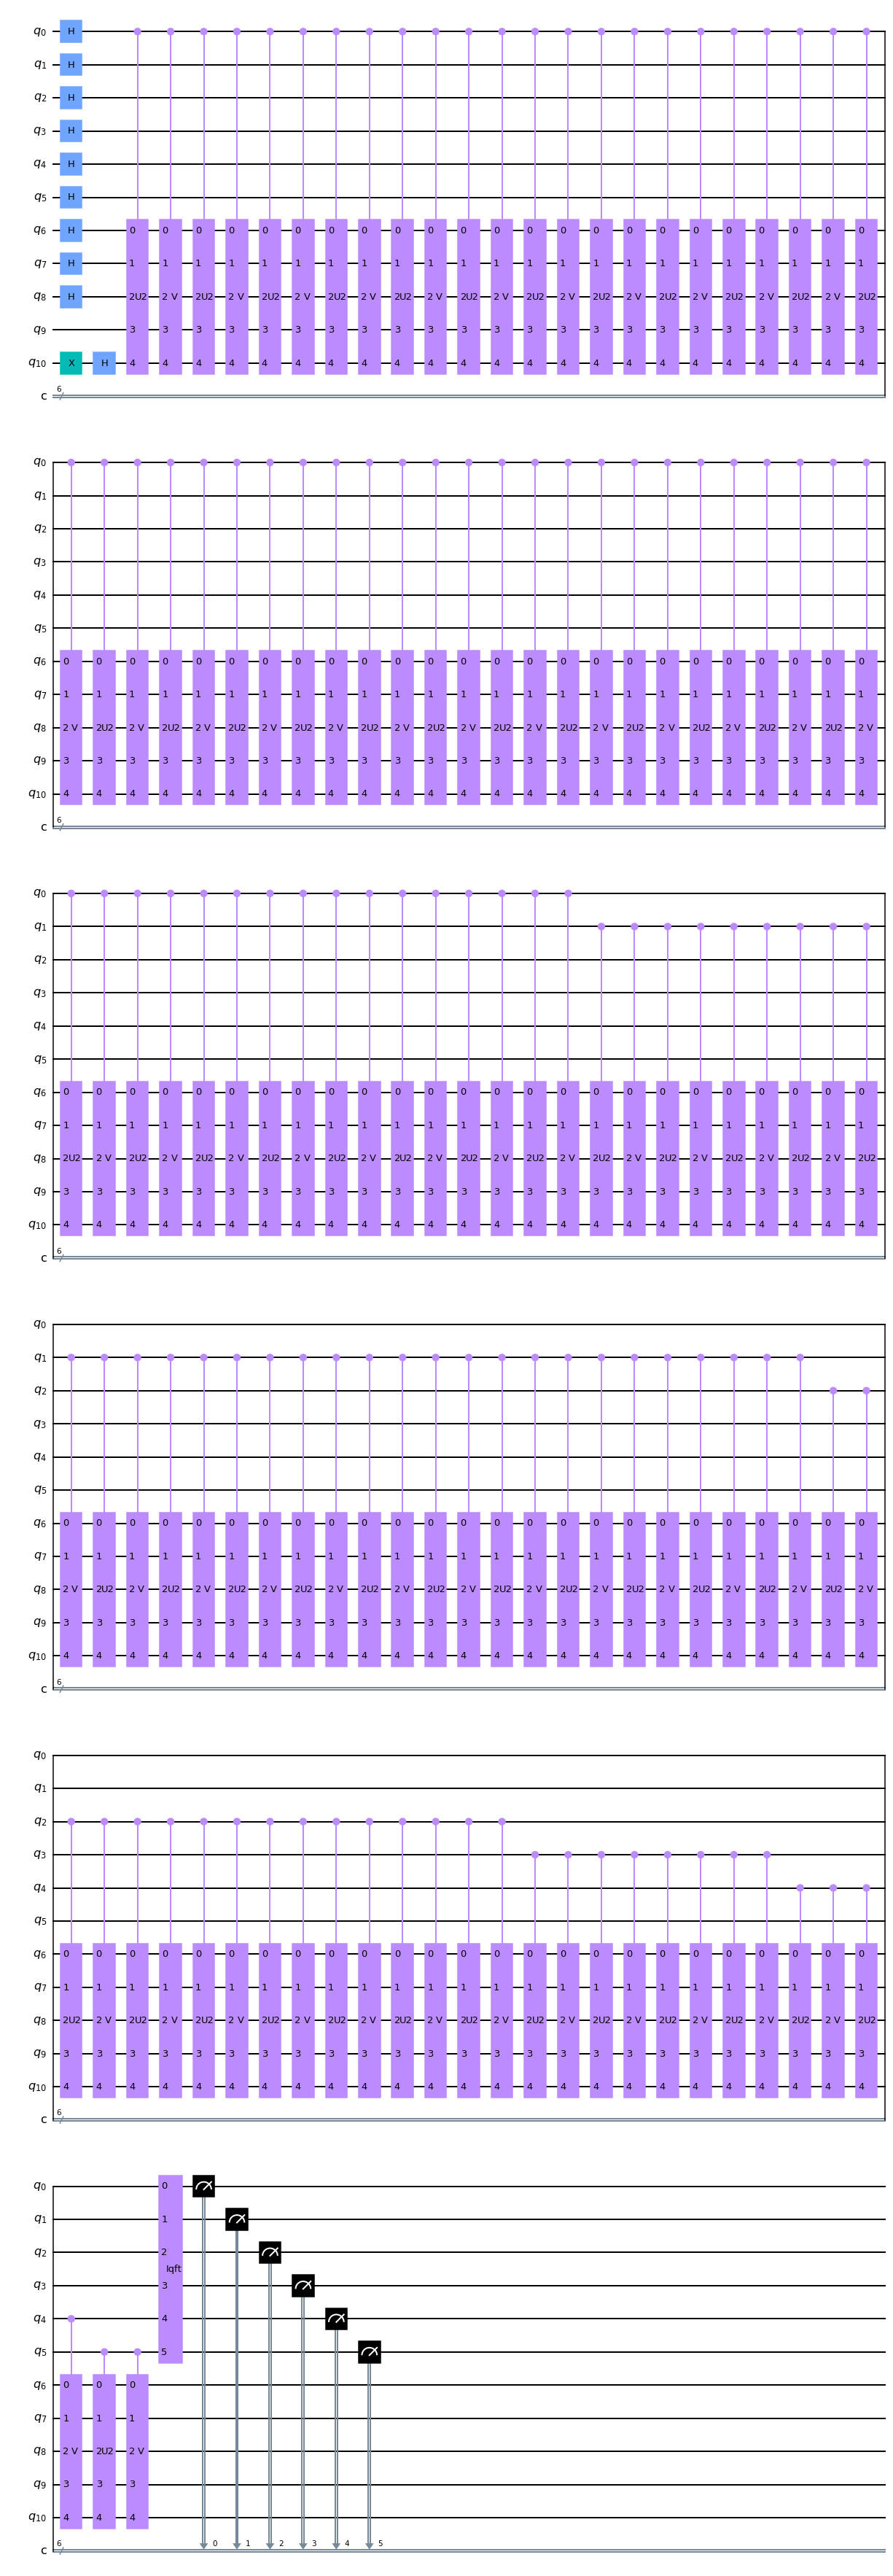

In [11]:
"""Build the Circuit for Quantum Phase Estimation for counting Purpose"""
n=5
c=6
qc=QuantumCircuit(n+c,c)

for qubit in range(n+c-2):
    qc.h(qubit)
# put ancilla in state |->
qc.x(n+c-1)
qc.h(n+c-1)
    
for x in range(c):
        exponent = 2**(c-x-1)
        for j in range(exponent):
            qc.append(Con_U,[x] + list(range(c, n+c)))
            qc.append(Con_V,[x] + list(range(c, n+c)))

qc.append(QFT(c).inverse(), range(c))       

for i in range(c):
    qc.measure(i,i)

qc.draw('mpl')

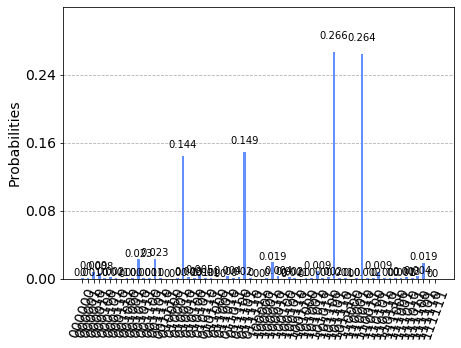

In [12]:
"""Plotting Histogram"""
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=10000).result().get_counts()
plot_histogram(counts)

In [13]:
import operator
highest_probability_string = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
hp_int=int(highest_probability_string,2)

In [14]:
"""This part calculate the number of solutions"""
import math as mt
N=2**(n-2)
theta=2*mt.pi*hp_int/(2**c)
M=N*(mt.sin(theta/2))**2
print('M = ',M)
print('N = ',N)
print('Number of solutions = ',N-M)

M =  5.16113870901785
N =  8
Number of solutions =  2.83886129098215


# $\bf\text{Problem 2}$

## First run the algorithm without noise

In [15]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np
pi = np.pi

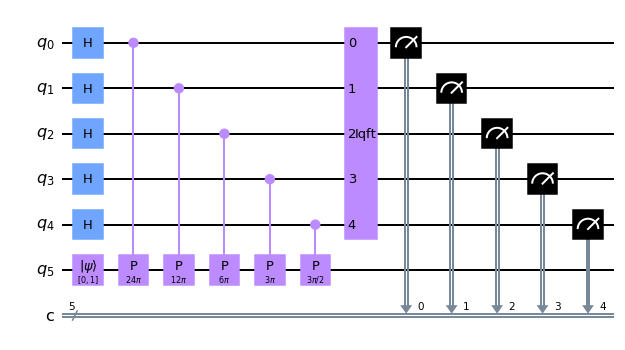

In [85]:
n=5
qc=QuantumCircuit(n+1,n)

for qubit in range(n):
    qc.h(qubit)

init_st=[0, 1]
qc.initialize(init_st,n)


theta=0.75
    
for x in range(n):
        exponent = 2**(n-x-1)
        qc.cp(2*pi*theta*exponent, x, n)

qc.append(QFT(n).inverse(), range(n))       

for i in range(n):
    qc.measure(i,i)

qc.draw('mpl')

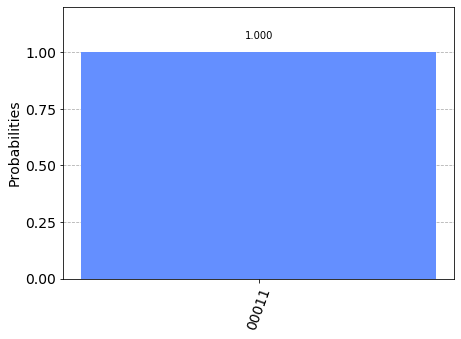

In [86]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=1000).result().get_counts()
plot_histogram(counts)

In [87]:
import operator
highest_probability_outcome = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
highest_probability_outcome

'11000'

In [88]:
measured_theta = int(highest_probability_outcome, 2)/2**n
print("Using ", n, " qubits with theta = ",theta, ", measured_theta = ", measured_theta)

Using  5  qubits with theta =  0.75 , measured_theta =  0.75


## Now, Introduce Noise

In [89]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

p=0.1
error_meas = pauli_error([('X',p), ('I', 1 - p)])


noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_meas, "measure")

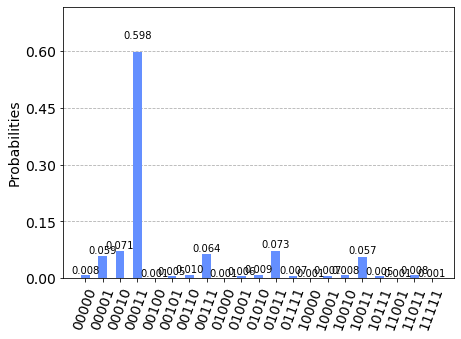

In [90]:
simulator =Aer.get_backend('qasm_simulator')
noisy_results = execute(qc, backend=simulator, shots=1000, noise_model=noise_model).result()
noisy_counts=noisy_results.get_counts()
#print(noisy_counts)
plot_histogram(noisy_counts)

In [91]:
import operator
highest_probability_outcome_noisy = max(noisy_counts.items(), key=operator.itemgetter(1))[0][::-1]
highest_probability_outcome_noisy

'11000'

In [92]:
noisy_theta = int(highest_probability_outcome_noisy, 2)/2**n
print("Using ", n, " qubits with theta = ",theta, ", noisy_theta = ", noisy_theta)

Using  5  qubits with theta =  0.75 , noisy_theta =  0.75


### ERROR

In [84]:
error = abs((noisy_theta-measured_theta)/(measured_theta))*100
print(f"Error is: {error}% ")

Error is: 0.0% 


# $\bf\text{Problem 3}$

#### $\text{Here, first we do not need Hadamard gate, because we do not need our qubits to rotate in xy-plane.}$
#### $\text{Second, we see that we want our qubits to rotate about y-axis. So instead of Controlled phase gates, we will apply controlled $R_y$ gates}.$

Enter Input state: 1111


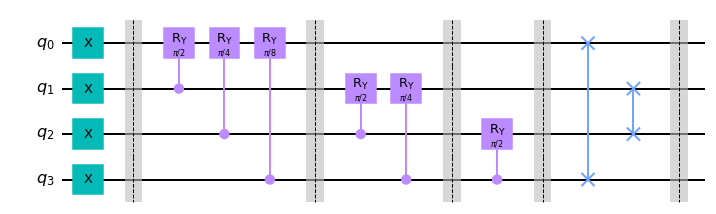

In [45]:
from qiskit import QuantumCircuit, execute, Aer, BasicAer
from qiskit.visualization import plot_histogram
from numpy import *


n = input("Enter Input state: ")
N=len(n)
qc=QuantumCircuit(N)
for i in range(N):
    if n[i]=='1':
        qc.x(i)
qc.barrier()

theta=pi/2
start = 1
for T in range(N-1):                # T: Target
    for C in range(start,N):        # C: Controlled
        qc.cry(theta,C,T)
        theta=theta/2
    qc.barrier()
    theta=pi/2
    start+=1

for ii in range(int(N/2)):
    qc.swap(ii,N-1-ii)
qc.barrier()
    
qc.draw('mpl')

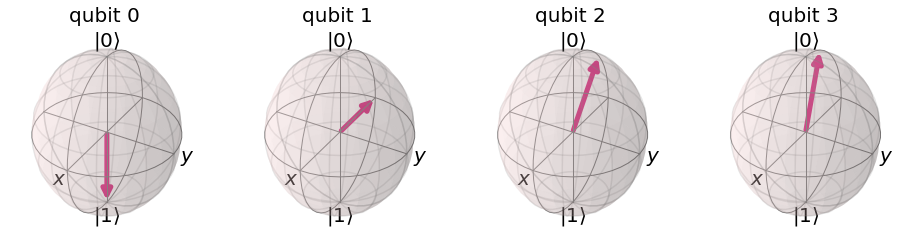

In [46]:
from qiskit.visualization import plot_histogram, plot_bloch_multivector
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)